<a href="https://colab.research.google.com/github/Vishveshwar08188/LSTM_Llmon-Network_GRU/blob/main/LSTM_Llmon_Network_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv("/parentheses_dataset_limited (1).csv")

In [ ]:
all_chars = sorted(set("".join(df["Sample"])))
char_to_idx = {char: i for i, char in enumerate(all_chars)}
idx_to_char = {i: char for char, i in char_to_idx.items()}

In [ ]:
max_seq_length = df["Sample"].apply(len).max()
max_seq_length

20

In [ ]:
def encode_sequence(seq):
    encoded = [char_to_idx[char] for char in seq]
    padded = encoded + [0] * (max_seq_length - len(encoded))
    return np.array(padded)

df["Encoded_Sequence"] = df["Sample"].apply(encode_sequence)

In [ ]:
X = np.vstack(df["Encoded_Sequence"].values)
y = df["Count"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
class BracketDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_loader = DataLoader(BracketDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(BracketDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wc = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_t = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        c_t = torch.zeros(x.size(0), self.hidden_size).to(x.device)

        for t in range(x.size(1)):
            x_t = x[:, t].float().unsqueeze(1)  # Extract character embedding
            combined = torch.cat((x_t, h_t), dim=1)
            f_t = torch.sigmoid(self.Wf(combined))
            i_t = torch.sigmoid(self.Wi(combined))
            o_t = torch.sigmoid(self.Wo(combined))
            c_tilde = torch.tanh(self.Wc(combined))
            c_t = f_t * c_t + i_t * c_tilde
            h_t = o_t * torch.tanh(c_t)

        return self.fc(h_t)

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(torch.device('cpu')), y_batch.to(torch.device('cpu'))
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            test_loss = sum(criterion(model(X), y).item() for X, y in test_loader) / len(test_loader)
            test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        # Add a learnable parameter
        self.bias = nn.Parameter(torch.ones(1))

    def forward(self, x):
        # Use the learnable parameter
        return self.bias.repeat(x.size(0), 1)  # Predicts a learnable constant value

In [ ]:
lstm_model = CustomLSTM(input_size=1, hidden_size=64, output_size=1)
baseline_model = BaselineModel()

In [ ]:
lstm_train_loss, lstm_test_loss = train_model(lstm_model, train_loader, test_loader, num_epochs=30)

Epoch 1/30, Train Loss: 0.3529, Test Loss: 0.3032
Epoch 2/30, Train Loss: 0.2790, Test Loss: 0.2607
Epoch 3/30, Train Loss: 0.2489, Test Loss: 0.2508
Epoch 4/30, Train Loss: 0.2271, Test Loss: 0.2145
Epoch 5/30, Train Loss: 0.1934, Test Loss: 0.1829
Epoch 6/30, Train Loss: 0.1876, Test Loss: 0.1784
Epoch 7/30, Train Loss: 0.1640, Test Loss: 0.1651
Epoch 8/30, Train Loss: 0.1461, Test Loss: 0.1490
Epoch 9/30, Train Loss: 0.1392, Test Loss: 0.1292
Epoch 10/30, Train Loss: 0.1369, Test Loss: 0.1366
Epoch 11/30, Train Loss: 0.1173, Test Loss: 0.1305
Epoch 12/30, Train Loss: 0.1080, Test Loss: 0.1096
Epoch 13/30, Train Loss: 0.1034, Test Loss: 0.1150
Epoch 14/30, Train Loss: 0.0967, Test Loss: 0.1070
Epoch 15/30, Train Loss: 0.0933, Test Loss: 0.0986
Epoch 16/30, Train Loss: 0.0791, Test Loss: 0.0954
Epoch 17/30, Train Loss: 0.0788, Test Loss: 0.0897
Epoch 18/30, Train Loss: 0.0699, Test Loss: 0.1170
Epoch 19/30, Train Loss: 0.0718, Test Loss: 0.0933
Epoch 20/30, Train Loss: 0.0690, Test Lo

In [ ]:
with torch.no_grad():
    baseline_predictions = torch.ones_like(y_test_tensor)
    baseline_loss = nn.MSELoss()(baseline_predictions, y_test_tensor).item()
    print(f'Baseline Model Test Loss: {baseline_loss:.4f}')

Baseline Model Test Loss: 0.4731


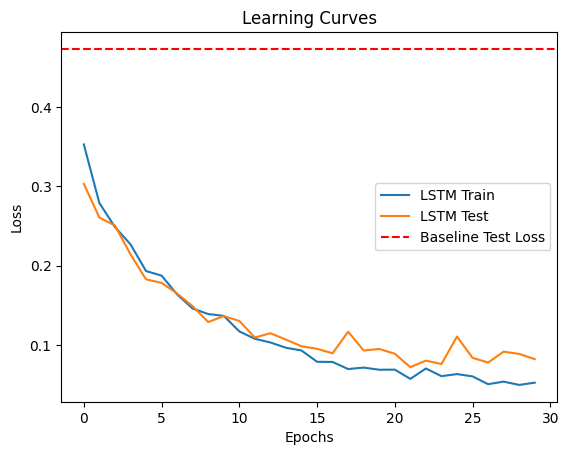

In [ ]:
plt.plot(lstm_train_loss, label='LSTM Train')
plt.plot(lstm_test_loss, label='LSTM Test')
plt.axhline(y=baseline_loss, color='r', linestyle='--', label='Baseline Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [ ]:
def sample_preds(model, X_test_tensor, y_test_tensor, num_samples=5):
    model.eval()
    with torch.no_grad():
        sample_indices = torch.randint(0, len(X_test_tensor), (num_samples,))
        sample_inputs = X_test_tensor[sample_indices]
        sample_targets = y_test_tensor[sample_indices]
        predictions = torch.round(model(sample_inputs))

        print("Sample Predictions:")
        for i in range(num_samples):
            print(f"Input: {sample_inputs[i]}")
            print(f"True Count: {sample_targets[i].item():.2f}, Predicted: {predictions[i].item():.2f}")

sample_preds(lstm_model, X_test_tensor, y_test_tensor)

Sample Predictions:
Input: tensor([72, 60, 66, 34, 68, 62, 79, 56, 68, 79,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
True Count: 0.00, Predicted: -0.00
Input: tensor([ 1, 65, 71, 74, 60, 79,  7, 71, 64, 73,  7,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
True Count: 0.00, Predicted: 0.00
Input: tensor([68, 73, 75, 80, 79,  7,  8, 13, 78, 75, 71, 68, 79,  7,  6,  1,  6,  8,
         0,  0])
True Count: 2.00, Predicted: 2.00
Input: tensor([13, 13, 13, 13, 13, 13,  1, 71, 64, 73,  7, 74, 75, 79,  0,  0,  0,  0,
         0,  0])
True Count: 0.00, Predicted: -0.00
Input: tensor([71, 68, 79,  7,  8,  8,  8,  0, 13, 13, 13, 13, 13, 13, 13, 13,  0,  0,
         0,  0])
True Count: 1.00, Predicted: 1.00


# Elmon network

Epoch 1/30, Loss: 0.3380, Accuracy: 0.6379
Epoch 2/30, Loss: 0.1275, Accuracy: 0.8439
Epoch 3/30, Loss: 0.0917, Accuracy: 0.8975
Epoch 4/30, Loss: 0.0619, Accuracy: 0.9499
Epoch 5/30, Loss: 0.0502, Accuracy: 0.9661
Epoch 6/30, Loss: 0.0332, Accuracy: 0.9828
Epoch 7/30, Loss: 0.0332, Accuracy: 0.9843
Epoch 8/30, Loss: 0.0277, Accuracy: 0.9870
Epoch 9/30, Loss: 0.0226, Accuracy: 0.9884
Epoch 10/30, Loss: 0.0257, Accuracy: 0.9869
Epoch 11/30, Loss: 0.0245, Accuracy: 0.9875
Epoch 12/30, Loss: 0.0172, Accuracy: 0.9930
Epoch 13/30, Loss: 0.0199, Accuracy: 0.9906
Epoch 14/30, Loss: 0.0178, Accuracy: 0.9920
Epoch 15/30, Loss: 0.0196, Accuracy: 0.9899
Epoch 16/30, Loss: 0.0159, Accuracy: 0.9920
Epoch 17/30, Loss: 0.0174, Accuracy: 0.9940
Epoch 18/30, Loss: 0.0194, Accuracy: 0.9901
Epoch 19/30, Loss: 0.0130, Accuracy: 0.9933
Epoch 20/30, Loss: 0.0138, Accuracy: 0.9937
Epoch 21/30, Loss: 0.0127, Accuracy: 0.9939
Epoch 22/30, Loss: 0.0158, Accuracy: 0.9916
Epoch 23/30, Loss: 0.0134, Accuracy: 0.99

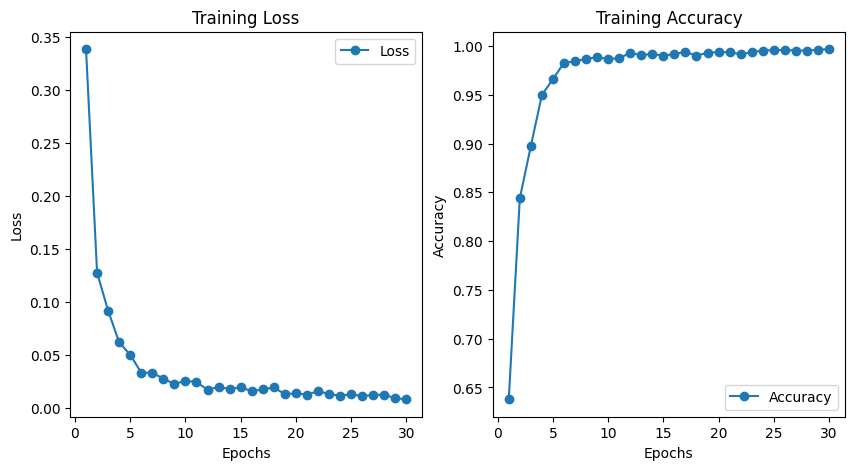

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence # Import pad_sequence


class ParenthesesDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.sequences = self.data['Sample'].values
        self.labels = self.data['Count'].values.astype(np.float32)
        self.char_to_index = {char: idx for idx, char in enumerate(sorted(set(''.join(self.sequences))))}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        encoded_seq = self.encode_sequence(sequence)
        return torch.tensor(encoded_seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    def encode_sequence(self, sequence):
        encoded = np.zeros((len(sequence), len(self.char_to_index)))
        for i, char in enumerate(sequence):
            if char in self.char_to_index:
                encoded[i, self.char_to_index[char]] = 1
        return encoded

class ElmonNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmonNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)  # Basic RNN cell
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        # batch_size, seq_len, _ = x.size()
        batch_size = x.size(0) # get batch size from the first dimension
        seq_len = x.size(1)
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)  # Initial hidden state

        for t in range(seq_len):
            h_t = self.rnn_cell(x[:, t, :], h_t)  # Update hidden state

        output = self.fc(h_t)  # Compute final output
        return output

# Load dataset
dataset = ParenthesesDataset('/parentheses_dataset_limited (1).csv')

def collate_fn(batch):
    sequences, labels = zip(*batch)
    # Pad the sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    # Stack the labels
    labels = torch.stack(labels)
    return padded_sequences, labels

train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn) # Use collate_fn in DataLoader

# Example of defining the model
input_size = len(dataset.char_to_index)  # One-hot encoding size
hidden_size = 64
output_size = 1  # Regression output (count of balanced pairs)

model = ElmonNetwork(input_size, hidden_size, output_size)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute accuracy (rounded to nearest integer)
            correct += (torch.round(outputs) == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        losses.append(total_loss / len(train_loader))
        accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), losses, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), accuracies, marker='o', label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.show()

# Define optimizer and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=30)


In [ ]:
def evaluate_model(model, dataset, num_samples=5):
    model.eval()
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    samples = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            samples.append((inputs.cpu().numpy(), targets.item(), outputs.item()))

    print("\nSample Test Results:")
    for i, (seq, target, pred) in enumerate(samples):
        print(f"Sample {i+1}: True Count = {target}, Predicted Count = {round(pred, 2)}")

# Evaluate on test sequences
evaluate_model(model, dataset)



Sample Test Results:
Sample 1: True Count = 1.0, Predicted Count = 1.31
Sample 2: True Count = 0.0, Predicted Count = 0.01
Sample 3: True Count = 0.0, Predicted Count = -0.01
Sample 4: True Count = 2.0, Predicted Count = 2.07
Sample 5: True Count = 0.0, Predicted Count = -0.01


# GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

Epoch 1/10, Loss: 0.4224
Epoch 2/10, Loss: 0.1556
Epoch 3/10, Loss: 0.1086
Epoch 4/10, Loss: 0.0872
Epoch 5/10, Loss: 0.0665
Epoch 6/10, Loss: 0.0530
Epoch 7/10, Loss: 0.0448
Epoch 8/10, Loss: 0.0392
Epoch 9/10, Loss: 0.0341
Epoch 10/10, Loss: 0.0310


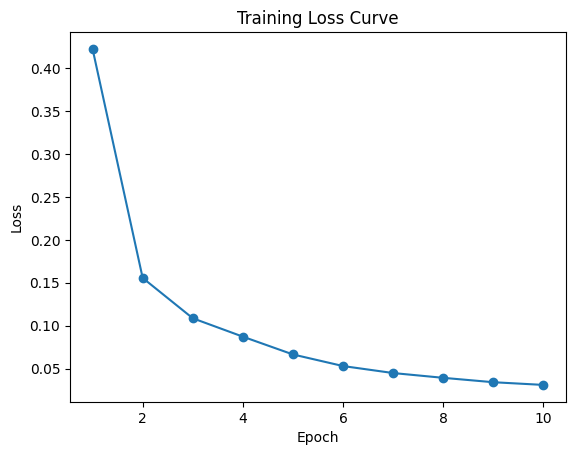

Test Loss: 0.0270
Mean Absolute Error (MAE): 0.1164
Root Mean Squared Error (RMSE): 0.0270
Tolerance-Based Accuracy (±1): 100.00%


In [ ]:
# Load dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

dataset_path = "/parentheses_dataset_limited (1).csv"  # Update with actual path if needed
df = pd.read_csv(dataset_path)

# Assume dataset has 'sequence' and 'count' columns
sequences = df['Sample'].values # Changed 'sequence' to 'Sample'
targets = df['Count'].values # Changed 'count' to 'Count'

# Character-level encoding
unique_chars = sorted(set(''.join(sequences)))
char_to_idx = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Reserve 0 for padding

# Convert sequences to numerical format
def encode_sequence(seq, max_len):
    encoded = [char_to_idx[char] for char in seq]
    return encoded + [0] * (max_len - len(encoded))  # Padding

max_seq_len = max(len(seq) for seq in sequences)
numerical_data = [encode_sequence(seq, max_seq_len) for seq in sequences]

# Convert to tensors
X = torch.tensor(numerical_data, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.float32)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch Dataset class
class ParenthesesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataloaders
train_dataset = ParenthesesDataset(X_train, y_train)
test_dataset = ParenthesesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        return self.fc(h_n.squeeze(0))

# Model parameters
vocab_size = len(unique_chars) + 1
embed_dim = 16
hidden_dim = 32
output_dim = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel(vocab_size, embed_dim, hidden_dim, output_dim).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot loss graph
    plt.plot(range(1, epochs+1), losses, marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    actuals, predictions = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            actuals.extend(y_batch.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    mae = mean_absolute_error(actuals, predictions)
    rmse = mean_squared_error(actuals, predictions) # Removed squared=False
    accuracy = np.mean(np.abs(np.array(actuals) - np.array(predictions)) <= 1) * 100

    print(f"Test Loss: {total_loss/len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Tolerance-Based Accuracy (±1): {accuracy:.2f}%")

# Evaluate the model
evaluate_model(model, test_loader)